<img src="AW&H2015.png" style="float: left">

<img src="flopylogo.png" style="float: center">

# And now we get to the NEXT BIG THING - Monte Carlo

As we've seen, FOSM is quick and insightful.  But FOSM depends on an assumption that the relation between the model and the forecast uncertainty is linear.  But many times the world is nonlinear. Short cuts like FOSM need assumptions, but we can free ourselves by taking the brute force approach.  That is define the parameters that are important, provide the prior uncertainty, sample those parameters many times, run the model many times, and then summarize the results.  

### Here's a flowchart from Anderson et al. (2015):

<img src="Fig10.14_MC_workflow.png" style="float: center">

What do we get when we do this?  We can get average heads for all the runs:

<img src="PB_avg_heads_Hunt2001.png" style="float: center">

But even cooler - we can get a map of standard deviation of those heads:

<img src="PB_stdev_heads_Hunt2001.png" style="float: center">

## Even cooler - a forecast can be related to stakeholders probabilistically!

<img src="FigB10.4.2_MC_probablistic_capture_zone.png" style="float: center">

### Objectives of this notebook

1) Run a real Monte Carlo run on the Freyberg model

2) Look at parameter and forecast uncertainty 

3) Start thinking of the advantages and disadvantages of linear and nonlinear uncertainty methods

# Quick reminder of what the model looks like:

It is a heterogenous 2D areal (1-layer) model that is a step up in complexity from our xsec model. Recall it looks like this:

<img src="Freyberg_k_plot_GW_Vistas.png" style="float: left">

### Standard two blocks needed to prep the notebook for what we cant to do

In [1]:
%matplotlib inline
import os
import sys
sys.path.append("..")
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyemu

In [2]:
import freyberg_setup
freyberg_setup.setup_pest_kr()
working_dir = freyberg_setup.WORKING_DIR_KR
pst_name = freyberg_setup.PST_NAME_KR

['.DS_Store', 'botm.ref', 'extract_zone_array.py', 'forecasts_true.csv', 'freyberg.bas', 'freyberg.dbf', 'freyberg.dis', 'freyberg.hds', 'freyberg.heads', 'freyberg.heads_potobs.ins', 'freyberg.hyd', 'freyberg.list', 'freyberg.locations', 'freyberg.mpbas', 'freyberg.mpenpt', 'freyberg.mplist', 'freyberg.mpnam', 'freyberg.mppthln', 'freyberg.mpsim', 'freyberg.oc', 'freyberg.pcg', 'freyberg.rivflux', 'freyberg.shp', 'freyberg.shx', 'freyberg.travel', 'freyberg.truth.lpf', 'freyberg.truth.nam', 'freyberg.truth.rch', 'freyberg.truth.riv', 'freyberg.truth.wel', 'hk.truth.ref', 'hk.zones', 'ibound.ref', 'kzone.ref', 'mpath.in', 'potobs_group.csv', 'Process_output.py', 'really_noisy_heads.txt', 'run_true_model.py', 'strt.ref', 'Weights_and_best_PHI.xlsx']

changing model workspace...
   freyberg_kr
FloPy is using the following executable to run the model: /Users/jwhite/Dev/GW1876/activities/freyberg_k_and_r_mc/freyberg_kr/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEO

## Let's do some Monte Carlo

Monte Carlo uses a lots and lots of forward runs so we don't want to make the mistake of burning the silicon for a PEST control file that is not right.  Here we make doubly sure that the control file has the recharge freed.  Note you can use this block in the future to your models....

In [3]:
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
pst.parameter_data

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
parnme,,,,,,,,,,
rch_0,rch_0,log,factor,1.0,0.75,1.25,rch,1.0,0.0,1
rch_1,rch_1,log,factor,1.0,0.75,1.25,rch,1.0,0.0,1
hk,hk,log,factor,5.0,0.50,50.00,hk,1.0,0.0,1


## Good - rch1 is freed.  Now let's draw 1000 tries from the parameter set.  

Look in the command below - how does it decide the range of parameters to pull from....

(this takes some time so wait for the 0 to show up below the code block before advancing)

In [6]:
prior_cov = pyemu.Cov.from_parameter_data(pst,sigma_range=6)
mc = pyemu.MonteCarlo(pst=pst,parcov=prior_cov)
mc.draw(num_reals=1000,enforce_bounds="reset")

###  Here's some parameter distributions you could use to control the values pulled from the parameter range from Anderson et al. (2015).  We're using a Gaussian, or "Normal" distribution in the code block above.

<img src="Fig10.13_parameter_distribution.png" style="float: left">

###  Here's an example of the first 5 parameter sets of our 1000 created by our draw ("draw" here is like "drawing" a card

In [7]:
mc.parensemble.head()

parnme,rch_0,rch_1,hk
0,0.876489,0.996511,10.324
1,0.918806,0.822845,3.82469
2,0.999214,0.841288,8.90829
3,1.08262,1.0604,7.61491
4,0.953917,1.02892,4.0404


Let's look at the distributions we are running

0.751352483428059 1.25 1.0022076942


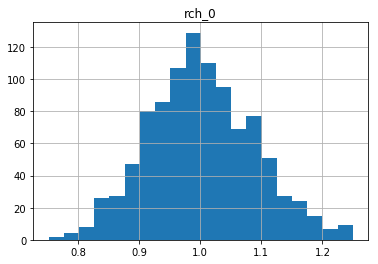

0.75 1.25 1.00177848852


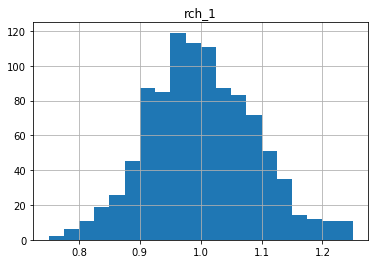

0.5 50.0 6.73424593723


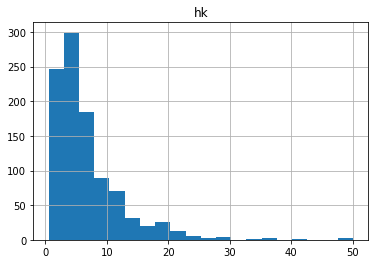

In [8]:
for pname in mc.pst.par_names:
    ax = mc.parensemble.loc[:,pname].hist(bins=20)
    print(mc.parensemble.loc[:,pname].min(),mc.parensemble.loc[:,pname].max(),mc.parensemble.loc[:,pname].mean())
    ax.set_title(pname)
    plt.show()
    

In [9]:
pst.parameter_data

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
parnme,,,,,,,,,,
rch_0,rch_0,log,factor,1.0,0.75,1.25,rch,1.0,0.0,1
rch_1,rch_1,log,factor,1.0,0.75,1.25,rch,1.0,0.0,1
hk,hk,log,factor,5.0,0.50,50.00,hk,1.0,0.0,1


Do the log transformed parameters look like a log normal distribution?

Now we'll make the sweep file of runs to distribute (just like in the response surface notebooks)

##  We are going to run the forward model 1000 times (!!!!) so it will take some time. 

In [26]:
mc.parensemble.to_csv(os.path.join(working_dir,"sweep_in.csv"))
os.chdir(working_dir)
pyemu.helpers.start_slaves('.',"sweep",pst_name,num_slaves=10,master_dir='.')
os.chdir("..")

master:sweep freyberg_kr.pst /h :4004 in .
slave:sweep freyberg_kr.pst /h localhost:4004 in ../slave_0
slave:sweep freyberg_kr.pst /h localhost:4004 in ../slave_1
slave:sweep freyberg_kr.pst /h localhost:4004 in ../slave_2
slave:sweep freyberg_kr.pst /h localhost:4004 in ../slave_3
slave:sweep freyberg_kr.pst /h localhost:4004 in ../slave_4
slave:sweep freyberg_kr.pst /h localhost:4004 in ../slave_5
slave:sweep freyberg_kr.pst /h localhost:4004 in ../slave_6
slave:sweep freyberg_kr.pst /h localhost:4004 in ../slave_7
slave:sweep freyberg_kr.pst /h localhost:4004 in ../slave_8
slave:sweep freyberg_kr.pst /h localhost:4004 in ../slave_9


## Alright - let's see some MC results.  For these runs, what was the Phi?

In [27]:
df_out = pd.read_csv(os.path.join(working_dir,"sweep_out.csv"),index_col=0)
df_out = df_out.loc[df_out.failed_flag==0,:] #drop an failed runs
df_out.columns = [c.lower() for c in df_out.columns]
df_out.head()

,input_run_id,failed_flag,phi,meas_phi,regul_phi,vol_storage,foreflux,flx_recharg,vol_wells,flx_storage,...,vol_total_19750101,vol_wells_19750101,vol_constan_19750102,vol_in-out_19750102,vol_percent_19750102,vol_recharg_19750102,vol_river_l_19750102,vol_storage_19750102,vol_total_19750102,vol_wells_19750102
run_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,3658.874191,3658.874191,0,0,0,0,0,0,...,813.0,-4348055.0,89536.234375,813.0,0.01,7118959.0,-2889362.50,32117.378906,813.0,-4350436.5
1,1,0,3553.955575,3553.955575,0,0,0,0,0,0,...,64.5,-4348055.0,-122012.593750,64.0,0.00,5880175.5,-1537961.75,130299.429688,64.0,-4350436.5
2,2,0,1233.182989,1233.182989,0,0,0,0,0,0,...,1410.5,-4348055.0,121635.031250,1411.0,0.02,6012251.0,-1849629.50,67590.664062,1411.0,-4350436.5
3,3,0,4301.182269,4301.182269,0,0,0,0,0,0,...,1215.0,-4348055.0,-89643.671875,1215.0,0.01,7576013.5,-3205296.00,70577.804688,1215.0,-4350436.5
4,4,0,2312.493623,2312.493623,0,0,0,0,0,0,...,913.0,-4348055.0,-245318.562500,914.0,0.01,7350646.5,-2850763.50,96785.765625,914.0,-4350436.5


### Let's plot Phi

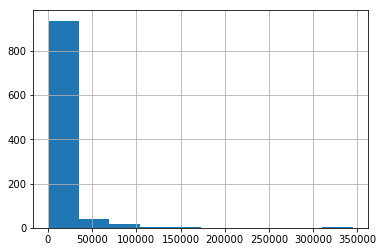

In [28]:
df_out.phi.hist()

### Wow, some of those models are really bad fits to the observations.  Those are not reasonable, so we should NOT include them in our uncertainty analysis.


# PAY ATTENTION:  this is super important - in this next block we are "conditioning" our Monte Carlo run by removing the bad runs. So here is the code where we are choosing which realizations we consider ``good enough`` with respect to fitting the observation data

In [30]:
acceptable_phi = 1000.0
good_enough = df_out.loc[df_out.phi<acceptable_phi].index.values
print(good_enough)

[ 16  21  54  76  95 107 116 118 121 144 160 163 213 228 231 234 245 254
 266 283 285 299 309 316 331 336 337 355 368 375 419 465 504 509 544 564
 566 574 610 615 625 629 653 675 683 730 736 764 801 826 867 874 888 897
 906 909 914 915 921 967 985]


#### So above is the list of run numbers that are meet our Phi cutoff

# Now the payoff - probablistic plots of our forecasts!s 

### Gray blocks show the range of the runs we threw out.  But those were considered within our bounds when we started, so those grey boxes represent our prior

### The blue boxes show the runs that met our criteria, so that distribution represents our posterior

In [31]:
print(df_out.columns)

Index(['input_run_id', 'failed_flag', 'phi', 'meas_phi', 'regul_phi',
       'vol_storage', 'foreflux', 'flx_recharg', 'vol_wells', 'flx_storage',
       ...
       'vol_total_19750101', 'vol_wells_19750101', 'vol_constan_19750102',
       'vol_in-out_19750102', 'vol_percent_19750102', 'vol_recharg_19750102',
       'vol_river_l_19750102', 'vol_storage_19750102', 'vol_total_19750102',
       'vol_wells_19750102'],
      dtype='object', length=2637)


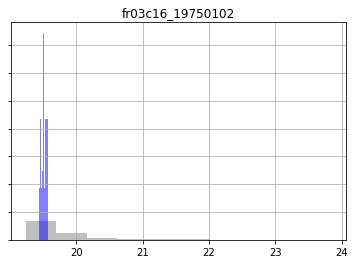

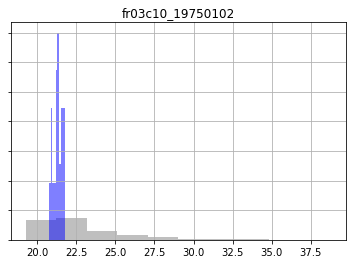

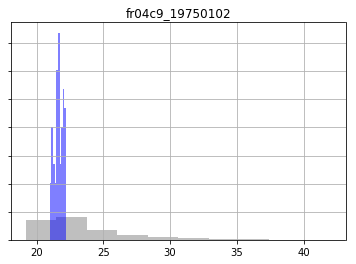

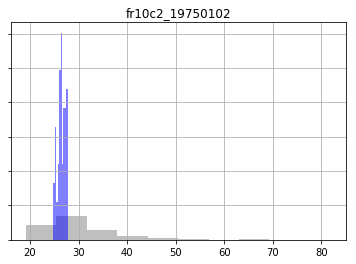

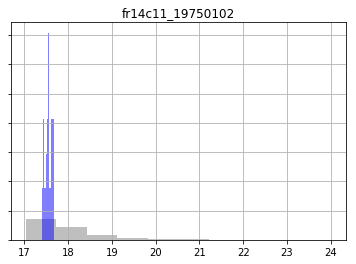

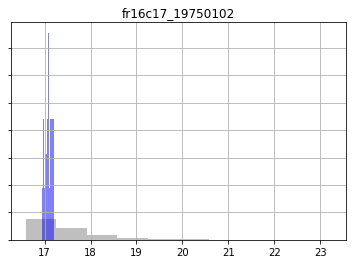

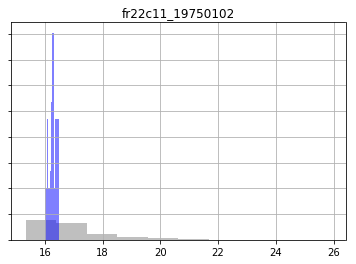

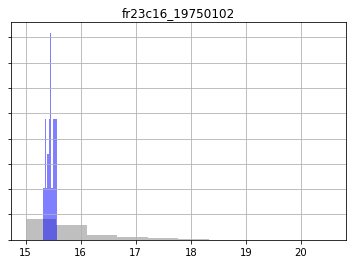

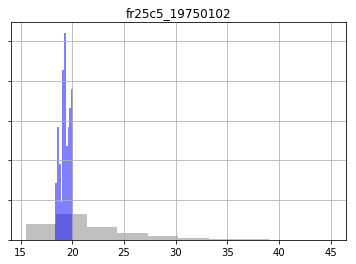

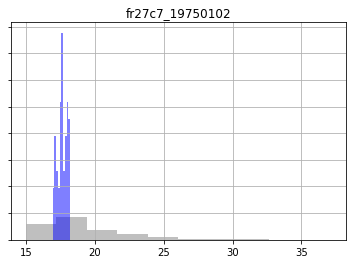

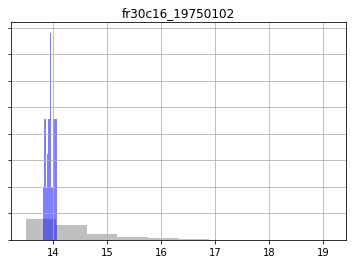

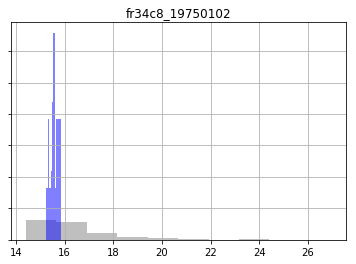

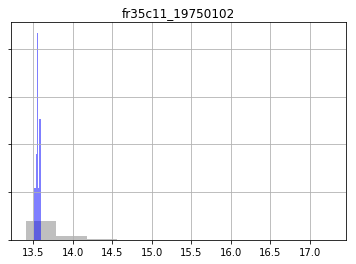

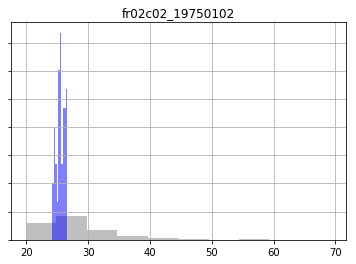

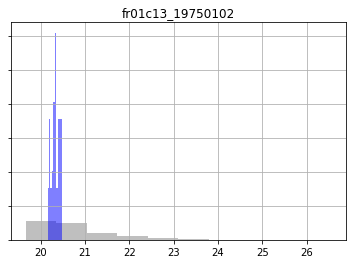

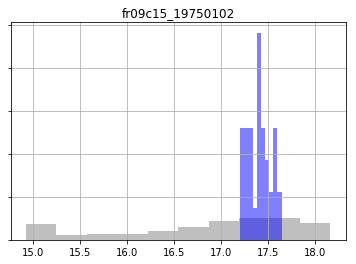

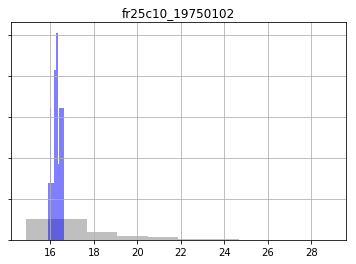

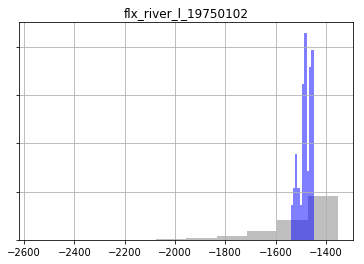

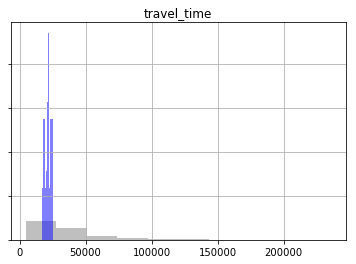

In [33]:
for forecast in pst.forecast_names:
    ax = df_out.loc[:,forecast].hist(alpha=0.5,color='0.5',normed=True)
    ax.set_yticklabels([])
    df_out.loc[good_enough,forecast].hist(ax=ax,alpha=0.5,color='b',normed=True)
    ax.set_title(forecast)
    plt.show()

# What a power POWERFUL method to show our uncertainty, and what we learned from history matching.  Moreover, we are free of a lot of the limiting assumptions of FOSM.  

(What's the downside?)